In [1]:
import pandas as pd

df = pd.read_feather('exp3_glue_scores.arrow') * 100

In [8]:
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 12.9 MB/s eta 0:00:00m eta 0:00:010:0101
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.9 MB/s eta 0:00:0031m13.6 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 12.9 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.7/310.7 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 13.0 MB/s eta 0:00:00m eta 0:00:010:01

[notice] A new release of pip available: 22.2.1 -> 24.0
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [2]:
GLUE_SCORE_FULL = [
    ('mrpc', 'eval_combined_score'),
    ('cola', 'eval_matthews_correlation'),
    ('mnli', 'eval_accuracy'),
    ('mnli', 'eval_accuracy_mm'),
    ('qqp', 'eval_combined_score'),
    ('rte', 'eval_accuracy'),
    ('stsb', 'eval_combined_score'),
    ('wnli', 'eval_accuracy'),
    ('qnli', 'eval_accuracy'),
    ('sst2', 'eval_accuracy'),
]
GLUE_SCORE_BERT = [
    ('mrpc', 'eval_combined_score'),
    ('cola', 'eval_matthews_correlation'),
    ('mnli', 'eval_accuracy'),
    ('mnli', 'eval_accuracy_mm'),
    ('qqp', 'eval_combined_score'),
    ('rte', 'eval_accuracy'),
    ('stsb', 'eval_combined_score'),
    ('qnli', 'eval_accuracy'),
    ('sst2', 'eval_accuracy'),
]

df['glue_score-full'] = df[GLUE_SCORE_FULL].apply(lambda x: x.mean(), axis=1)
df['glue_score-bert'] = df[GLUE_SCORE_BERT].apply(lambda x: x.mean(), axis=1)

In [3]:
df_ = df.reset_index()

In [4]:
acc_final = df.loc[("bert_base_pairwise_20240204-093411", 200000)]['glue_score-bert']
acc95 = 0.95 * acc_final

In [5]:
acc_final

metric
    79.052139
Name: (bert_base_pairwise_20240204-093411, 200000), dtype: float64

In [6]:
import numpy as np
acc95 = 75.0975

xs = df_[df_.model == "bert_base_vanilla_20240204-093411"]['ckpt'].tolist()

ys0 = df_[df_.model == "bert_base_pairwise_20240204-093411"]['glue_score-bert'].tolist()
acc95_x0 = np.interp(acc95, ys0, xs)

ys1 = df_[df_.model == "bert_base_vanilla_20240204-093411"]['glue_score-bert'].tolist()
acc95_x1 = np.interp(acc95, ys1, xs)

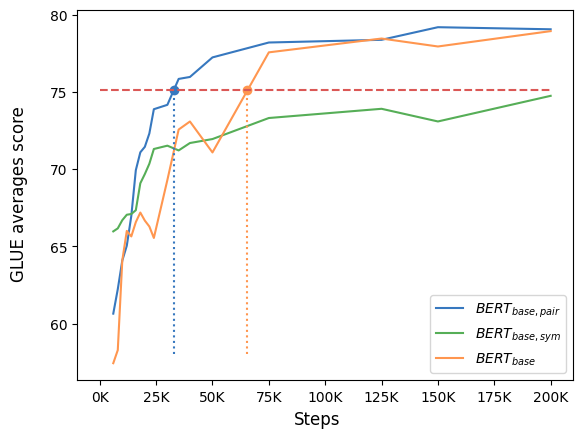

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

fig, ax = plt.subplots()

LABELS = {
    'bert_base_symmetric': '$BERT_{base,sym}$',
    'bert_base_pairwise': '$BERT_{base,pair}$',
    'bert_base_vanilla': '$BERT_{base}$',
}

COLORS = {
    'bert_base_symmetric': 'xkcd:dark pastel green',
    'bert_base_pairwise': 'xkcd:windows blue',
    'bert_base_vanilla': 'xkcd:pastel orange',
}


for key, grp in df_.groupby('model'):
    label = '_'.join(key.split('_')[0:3])
    ax = grp.plot(ax=ax, kind='line', x='ckpt', y='glue_score-bert', color=COLORS[label], label=LABELS[label])
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{}'.format(int(x/1000)) + 'K'))
    ax.xaxis.set_label_text('')

plt.hlines(acc95, 0, 200000, color='xkcd:pastel red', linestyles='dashed')
plt.vlines(acc95_x0, 58, acc95, color=COLORS['bert_base_pairwise'], linestyles='dotted')
plt.vlines(acc95_x1, 58, acc95, color=COLORS['bert_base_vanilla'], linestyles='dotted')
plt.scatter(acc95_x0, acc95, color=COLORS['bert_base_pairwise'])
plt.scatter(acc95_x1, acc95, color=COLORS['bert_base_vanilla'])

fig.supxlabel('Steps')
fig.supylabel('GLUE average score')

plt.legend(loc='lower right')
plt.show()

In [17]:
fig.savefig('exp3_glue_score_over_checkpoints.png')